In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import json
import pandas as pd
import numpy as np
from PIL import Image

import tensorflow as tf
#tf.enable_eager_execution()
#import tensorflow.contrib.eager as tfe
import sys
import os
from sklearn.utils import shuffle
from random import sample
# from cache import cache
# import pydot
# import graphviz
# from sklearn.model_selection import train_test_split
import time
import pickle
from tqdm import tqdm
# import copy
# import re
# import random
import requests

In [2]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Dense, Dropout, Activation, Flatten, Reshape, \
BatchNormalization, GlobalAveragePooling2D, Conv2D
from tensorflow.python.keras.applications.vgg16 import VGG16
from tensorflow.python.keras.applications.vgg16 import preprocess_input as VGG16_preprocess_input
from tensorflow.python.keras.applications.inception_v3 import InceptionV3
from tensorflow.python.keras.applications.inception_v3 import preprocess_input
from tensorflow.python.keras.applications.inception_v3 import decode_predictions
from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import ModelCheckpoint, TensorBoard
#from tensorflow.python.keras.utils import plot_model
#from tensorflow.python.keras.utils import to_categorical

In [3]:
tf.__version__

'2.1.0'

In [4]:
tf.keras.__version__

'2.2.4-tf'

In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4370487211399208053
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 15782324901469905154
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 15755135770325363480
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:1"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 12351089441399589676
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15704447386
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16638609047337551660
physical_device_desc: "device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:00:07.0, compute capability: 7.0"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 15704447386
locality {
  bus_id: 1
  links {
  }
}
incarnation:

In [6]:
print(tf.test.is_built_with_cuda())

True


# Load Data for Modeling

In [7]:
PATH = "/mnt/disk1/"

In [8]:
# get data from json
with open(PATH + "data/caltech_images_20190919.json", 'r') as f:
    annotations = json.load(f)

annot_df = pd.DataFrame.from_dict(annotations['annotations'])
image_df = pd.DataFrame.from_dict(annotations['images'])

# get animal name map 
category_id = []
category_name = []

for i in annotations['categories']:
    category_id.append(i['id'])
    category_name.append(i['name'])
    
category_dict = dict(zip(category_id, category_name))
annot_df['category_name'] = annot_df['category_id'].map(category_dict)

# drop duplicate annotations
annot_df.sort_values("image_id", inplace = True) 
annot_df_nodup = annot_df.drop_duplicates(subset ="image_id", keep = 'first')

# merge annotation and image data together
image_df.rename(columns={"id": "image_id"}, inplace=True)
image_df.sort_values("image_id", inplace = True) 
image_df_annot = pd.concat([image_df.set_index('image_id'), annot_df_nodup.set_index('image_id')], axis=1, join='inner').reset_index()

image_df_annot.head()

,image_id,seq_num_frames,date_captured,seq_id,height,width,location,rights_holder,file_name,frame_num,id,category_id,category_name
0,5858bf1e-23d2-11e8-a6a3-ec086b02610b,1,2014-07-10 14:20:20,6fc5ac4a-5567-11e8-b3db-dca9047ef277,1494,2048,96,Erin Boydston,test/5858bf1e-23d2-11e8-a6a3-ec086b02610b.jpg,1,52acca15-7d6d-11e7-884d-7845c41c2c67,30,empty
1,5858bf20-23d2-11e8-a6a3-ec086b02610b,1,2014-05-26 13:44:00,6fbb3c73-5567-11e8-b378-dca9047ef277,1494,2048,96,Erin Boydston,test/5858bf20-23d2-11e8-a6a3-ec086b02610b.jpg,1,f77c64a8-7d6e-11e7-884d-7845c41c2c67,30,empty
2,5858bf21-23d2-11e8-a6a3-ec086b02610b,1,2014-09-16 08:16:51,7006f717-5567-11e8-b4c6-dca9047ef277,1494,2048,114,Erin Boydston,test/5858bf21-23d2-11e8-a6a3-ec086b02610b.jpg,1,1aa83e59-7d71-11e7-884d-7845c41c2c67,10,rabbit
3,5858bf22-23d2-11e8-a6a3-ec086b02610b,1,2014-05-27 14:57:44,6fbd60e3-5567-11e8-a122-dca9047ef277,1494,2048,96,Erin Boydston,test/5858bf22-23d2-11e8-a6a3-ec086b02610b.jpg,1,45913ae8-7d6d-11e7-884d-7845c41c2c67,30,empty
4,5858bf23-23d2-11e8-a6a3-ec086b02610b,1,2014-06-06 12:31:06,6fbf5a47-5567-11e8-9655-dca9047ef277,1494,2048,96,Erin Boydston,test/5858bf23-23d2-11e8-a6a3-ec086b02610b.jpg,1,5f7e6e7a-7d6e-11e7-884d-7845c41c2c67,30,empty


# Show Image

In [9]:
def load_image(path, size=None):
    """
    Load the image from the given file-path and resize it
    to the given size if not None.
    """

    # Load the image using PIL.
    img = Image.open(path)

    # Resize image if desired.
    if not size is None:
        img = img.resize(size=size, resample=Image.LANCZOS)

    # Convert image to numpy array.
    img = np.array(img)

    # Scale image-pixels so they fall between 0.0 and 1.0
    img = img / 255.0

    # Convert 2-dim gray-scale array to 3-dim RGB array.
    if (len(img.shape) == 2):
        img = np.repeat(img[:, :, np.newaxis], 3, axis=2)

    return img

def show_image(path, category):
    """
    Load and plot an image from the training- or validation-set
    with the given index.
    """

    #path = filenames_train[idx]
    #caption = captions_train[idx]

    # Print the captions for this image.
    print("Category: " + category)
    
    # Load the image and plot it.
    img = load_image(path)
    plt.imshow(img)
    plt.show()
    
def show_image_by_category(images=1, category = 'any'):
    path = PATH + 'data/cct_images/'
    if category == 'any':
        samples = image_df_annot.sample(n=images)
    else:
        samples = image_df_annot[image_df_annot['category_name']==category].sample(n=images)
    for id, sample in samples.iterrows():
        image_id = sample['image_id']
        filename= path +image_id + '.jpg'
        print(sample['category_name'] + " " + image_id)
        img = load_image(filename)
        plt.imshow(img)
        plt.show()    

# Define Prediction Class

In [10]:
classes = ['rodent','squirrel','rabbit','bird','deer','raccoon','skunk','opossum']
classes_dict = dict(zip(classes + ['other'] + ['empty'], range(10)))
classes_dict_lookup = dict(zip(range(10), classes + ['other'] + ['empty']))

In [11]:
classes_dict

{'rodent': 0,
 'squirrel': 1,
 'rabbit': 2,
 'bird': 3,
 'deer': 4,
 'raccoon': 5,
 'skunk': 6,
 'opossum': 7,
 'other': 8,
 'empty': 9}

In [12]:
orig_class = list(image_df_annot['category_name'].unique())
new_class = [animal if animal in classes + ['empty'] else 'other' for animal in orig_class]
prediction_class_map = dict(zip(orig_class, new_class))

In [13]:
prediction_class_map

{'empty': 'empty',
 'rabbit': 'rabbit',
 'bobcat': 'other',
 'squirrel': 'squirrel',
 'raccoon': 'raccoon',
 'coyote': 'other',
 'bird': 'bird',
 'car': 'other',
 'opossum': 'opossum',
 'cow': 'other',
 'skunk': 'skunk',
 'dog': 'other',
 'deer': 'deer',
 'fox': 'other',
 'cat': 'other',
 'rodent': 'rodent',
 'mountain_lion': 'other',
 'lizard': 'other',
 'badger': 'other',
 'insect': 'other',
 'pig': 'other',
 'bat': 'other'}

In [14]:
image_df_annot['category_name_model'] = image_df_annot['category_name'].map(prediction_class_map)
image_df_annot['category_id_model'] = image_df_annot['category_name_model'].map(classes_dict)
image_df_annot = image_df_annot.sample(frac=1, random_state=1)

In [15]:
image_df_annot.groupby('category_name_model').image_id.count().sort_values()

category_name_model
skunk         1892
rodent        4272
squirrel      4432
bird          9521
raccoon      10981
deer         12191
rabbit       12345
opossum      16634
other        45087
empty       125745
Name: image_id, dtype: int64

In [16]:
image_df_annot.head()

,image_id,seq_num_frames,date_captured,seq_id,height,width,location,rights_holder,file_name,frame_num,id,category_id,category_name,category_name_model,category_id_model
6587,5865e214-23d2-11e8-a6a3-ec086b02610b,1,2014-02-04 12:00:00,6f58f0fa-5567-11e8-b7cf-dca9047ef277,1494,2048,76,Erin Boydston,test/5865e214-23d2-11e8-a6a3-ec086b02610b.jpg,1,702bba8a-7d68-11e7-884d-7845c41c2c67,30,empty,empty,9
146671,5976a528-23d2-11e8-a6a3-ec086b02610b,3,2013-10-16 02:40:38,70171454-5567-11e8-8773-dca9047ef277,1494,2048,6,Justin Brown,train_val/5976a528-23d2-11e8-a6a3-ec086b02610b...,1,e97429c7-7de8-11e7-884d-7845c41c2c67,34,deer,deer,4
14460,5874d618-23d2-11e8-a6a3-ec086b02610b,1,2014-08-30 19:00:00,6f6474c0-5567-11e8-9064-dca9047ef277,1494,2048,76,Erin Boydston,test/5874d618-23d2-11e8-a6a3-ec086b02610b.jpg,1,7b641085-7d68-11e7-884d-7845c41c2c67,30,empty,empty,9
9032,586adde6-23d2-11e8-a6a3-ec086b02610b,1,2014-06-06 04:00:00,6fbf50e8-5567-11e8-a3df-dca9047ef277,1494,2048,96,Erin Boydston,test/586adde6-23d2-11e8-a6a3-ec086b02610b.jpg,1,72de5786-7d6f-11e7-884d-7845c41c2c67,30,empty,empty,9
116374,593bdc40-23d2-11e8-a6a3-ec086b02610b,1,2014-05-26 12:09:34,6fba0502-5567-11e8-885c-dca9047ef277,1494,2048,96,Erin Boydston,test/593bdc40-23d2-11e8-a6a3-ec086b02610b.jpg,1,c38e181d-7d6d-11e7-884d-7845c41c2c67,30,empty,empty,9


# Data Partition by Location

In [19]:
# download suggested split from data website
url = 'https://lilablobssc.blob.core.windows.net/caltechcameratraps/CaltechCameraTrapsSplits_v0.json'
split = requests.get(url).json()

# use suggested split for test
train_val_loc = sorted(list(set(split['splits']['train'])))
test_locs = sorted(list(set(split['splits']['val'])))

len(train_val_loc)

len(test_locs)

# furthur split training and validation
test_loc = shuffle(test_locs, random_state=2)
test_loc = test_locs[:20]
val_loc = test_locs[20:]

data_train = image_df_annot[image_df_annot['location'].isin(train_val_loc)]
data_val = image_df_annot[image_df_annot['location'].isin(val_loc)]
data_test = image_df_annot[image_df_annot['location'].isin(test_loc)]

print(data_train.shape)
print(data_val.shape)
print(data_test.shape)

# get image vector
img_vector_train = list(PATH + 'data/cct_images/' + data_train['image_id'] + '.jpg')
img_vector_val = list(PATH + 'data/cct_images/' + data_val['image_id'] + '.jpg')
img_vector_test = list(PATH + 'data/cct_images/' + data_test['image_id'] + '.jpg')

# get category vector
cat_name_vector_train = list(data_train['category_name_model'])
cat_id_vector_train = list(data_train['category_id_model'])

cat_name_vector_val = list(data_val['category_name_model'])
cat_id_vector_val = list(data_val['category_id_model'])

cat_name_vector_test = list(data_test['category_name_model'])
cat_id_vector_test = list(data_test['category_id_model'])

40

Category: empty


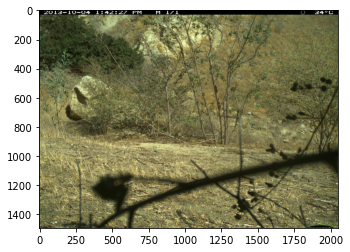

In [25]:
id = 5
show_image(img_vector_train[id], cat_name_vector_train[id])

# Encode Images with InceptionV3 For Faster Training

In [22]:
# Get the InceptionV3 model trained on imagenet data
inception_v3 = InceptionV3(weights='imagenet')

# Take -3 layer with shape (8,8,2048)
#inception_v3_body = Model(inception_v3.input, inception_v3.layers[-3].output)

In [23]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [24]:
with strategy.scope():
    inception_v3_body = Model(inception_v3.input, inception_v3.layers[-3].output) 

inception_v3_body.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [33]:
inception_v3_body.output

<tf.Tensor 'mixed10/Identity:0' shape=(None, 8, 8, 2048) dtype=float32>

In [151]:
def load_image_for_inception(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = preprocess_input(img)
    return img, image_path

In [26]:
image_dataset = tf.data.Dataset.from_tensor_slices(img_vector_train)
image_dataset = image_dataset.map(load_image_for_inception, 
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(96)

for img, path in tqdm(image_dataset):
    batch_features = inception_v3_body(img)
    #batch_features = tf.reshape(batch_features,(tf.shape(batch_features)[0], -1, tf.shape(batch_features)[3]))

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8").replace('cct_images','train')
        np.save(path_of_feature, bf.numpy())
        
# 115212 images, 64 batch size, expect 1801 batches

1506it [06:21,  3.94it/s]


In [27]:
image_dataset = tf.data.Dataset.from_tensor_slices(img_vector_val)
image_dataset = image_dataset.map(load_image_for_inception, 
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(96)

for img, path in tqdm(image_dataset):
    batch_features = inception_v3_body(img)
    #batch_features = tf.reshape(batch_features,(tf.shape(batch_features)[0], -1, tf.shape(batch_features)[3]))

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8").replace('cct_images','val')
        np.save(path_of_feature, bf.numpy())
        
# 65478 images, 64 batch size, expect 1024 batches

377it [01:37,  3.86it/s]


In [28]:
image_dataset = tf.data.Dataset.from_tensor_slices(img_vector_test)
image_dataset = image_dataset.map(load_image_for_inception, 
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(96)

for img, path in tqdm(image_dataset):
    batch_features = inception_v3_body(img)
    #batch_features = tf.reshape(batch_features,(tf.shape(batch_features)[0], -1, tf.shape(batch_features)[3]))

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8").replace('cct_images','test')
        np.save(path_of_feature, bf.numpy())
        
# 62410 images, 64 batch size, expect 976 batches

651it [02:46,  3.91it/s]


# Modeling - Transfer Learning with InceptionV3

In [ ]:
# take InceptionV3 without last layer
# model_transfer = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

In [35]:
from tensorflow.keras import optimizers
adam = optimizers.Adam(lr=0.0001)

In [36]:
def create_model():
    # add new trainable last layer and build model
    transfer_input = Input(shape=(8,8,2048))
    x = GlobalAveragePooling2D()(transfer_input)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.8)(x)
    x = Dense(10, activation="softmax")(x)
    model = Model(transfer_input, x)
    return model

In [37]:
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    parallel_model = create_model() 
    parallel_model.compile(optimizer=adam, loss='sparse_categorical_crossentropy')

parallel_model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 8, 8, 2048)]      0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               262272    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 263,562
Trainable params: 263,562
Non-trainable params: 0
____________________________________

### Generator Functions

In [29]:
def load_encoding(path, train_test_val):
    return np.load(path.replace('cct_images', train_test_val) + '.npy')

In [30]:
def generator_encoded(X_data, y_data, batch_size, train_test_val):
    i = 0
    while True:
        X_batch = []
        y_batch = []
        
        for b in range(batch_size):
            if i >= len(X_data):
                i = 0
                
            X = load_encoding(X_data[i], train_test_val)
            y = y_data[i]
            X_batch.append(X)
            y_batch.append(y)
            i += 1
            
        yield np.array(X_batch), np.array(y_batch)

### Train Model

In [38]:
# test on 1024 images
sample_x_train = img_vector_train[:4096]
sample_y_train = cat_id_vector_train[:4096]

sample_x_val = img_vector_val[:64]
sample_y_val = cat_id_vector_val[:64]

In [31]:
class_dist = dict(image_df_annot.groupby('category_id_model').image_id.count().sort_values())
class_dist

{6: 1892,
 0: 4272,
 1: 4432,
 3: 9521,
 5: 10981,
 4: 12191,
 2: 12345,
 7: 16634,
 8: 45087,
 9: 125745}

In [32]:
total = sum(class_dist.values())
class_dist_inverse = {k: total/v for k, v in class_dist.items()}

In [33]:
class_dist_inverse

{6: 128.48837209302326,
 0: 56.905430711610485,
 1: 54.851083032490976,
 3: 25.533032244512132,
 5: 22.13823877606775,
 4: 19.940940037732755,
 2: 19.692183070068854,
 7: 14.614644703619094,
 8: 5.391798079268969,
 9: 1.9332776651159091}

In [42]:
set(sample_y_train)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [163]:
# train model with encoded data - much faster - 1024 dense layer
# full data
EPOCH = 15
BATCH_SIZE = 256
TRAIN_STEPS = len(img_vector_train)//BATCH_SIZE
VAL_STEPS = len(img_vector_val)//BATCH_SIZE

#TRAIN_STEPS = len(sample_x_train)//BATCH_SIZE
#VAL_STEPS = len(sample_x_val)//BATCH_SIZE


train_generator = generator_encoded(img_vector_train, cat_id_vector_train, BATCH_SIZE, 'train')
val_generator = generator_encoded(img_vector_val, cat_id_vector_val, BATCH_SIZE, 'train')

#train_generator = generator_encoded(sample_x_train, sample_y_train, BATCH_SIZE, 'train')
#val_generator = generator_encoded(sample_x_val, sample_y_val, BATCH_SIZE, 'val')


for i in range(EPOCH):
    parallel_model.fit_generator(generator=train_generator, \
                        validation_data=val_generator,\
                        validation_steps=VAL_STEPS, \
                        steps_per_epoch=TRAIN_STEPS, \
                        epochs=1, verbose=1,\
                        class_weight=class_dist_inverse)
    parallel_model.save('./weights/modelv_2/model_' + str(i) + '.h5')

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 705 steps, validate for 112 steps
INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
704/705 [============================>.] - E

In [43]:
# train model with encoded data - 256 dense layer and learning rate = 0.0001
# full data
EPOCH = 15
BATCH_SIZE = 256
TRAIN_STEPS = len(img_vector_train)//BATCH_SIZE
VAL_STEPS = len(img_vector_val)//BATCH_SIZE

#TRAIN_STEPS = len(sample_x_train)//BATCH_SIZE
#VAL_STEPS = len(sample_x_val)//BATCH_SIZE


train_generator = generator_encoded(img_vector_train, cat_id_vector_train, BATCH_SIZE, 'train')
val_generator = generator_encoded(img_vector_val, cat_id_vector_val, BATCH_SIZE, 'train')

#train_generator = generator_encoded(sample_x_train, sample_y_train, BATCH_SIZE, 'train')
#val_generator = generator_encoded(sample_x_val, sample_y_val, BATCH_SIZE, 'val')


for i in range(EPOCH):
    parallel_model.fit_generator(generator=train_generator, \
                        validation_data=val_generator,\
                        validation_steps=VAL_STEPS, \
                        steps_per_epoch=TRAIN_STEPS, \
                        epochs=1, verbose=1,\
                        class_weight=class_dist_inverse)
    parallel_model.save('./weights/modelv_5/model_' + str(i) + '.h5')

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 705 steps, validate for 112 steps
INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/re

In [34]:
# train model with encoded data - 256 dense layer and learning rate = 0.0001 and dropout 0.6
# full data
EPOCH = 15
BATCH_SIZE = 256
TRAIN_STEPS = len(img_vector_train)//BATCH_SIZE
VAL_STEPS = len(img_vector_val)//BATCH_SIZE

#TRAIN_STEPS = len(sample_x_train)//BATCH_SIZE
#VAL_STEPS = len(sample_x_val)//BATCH_SIZE


train_generator = generator_encoded(img_vector_train, cat_id_vector_train, BATCH_SIZE, 'train')
val_generator = generator_encoded(img_vector_val, cat_id_vector_val, BATCH_SIZE, 'train')

#train_generator = generator_encoded(sample_x_train, sample_y_train, BATCH_SIZE, 'train')
#val_generator = generator_encoded(sample_x_val, sample_y_val, BATCH_SIZE, 'val')


for i in range(EPOCH):
    parallel_model.fit_generator(generator=train_generator, \
                        validation_data=val_generator,\
                        validation_steps=VAL_STEPS, \
                        steps_per_epoch=TRAIN_STEPS, \
                        epochs=1, verbose=1,\
                        class_weight=class_dist_inverse)
    parallel_model.save('./weights/modelv_6/model_' + str(i) + '.h5')

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 705 steps, validate for 112 steps
INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/re

  ...
    to  
  ['...']
Train for 705 steps, validate for 112 steps
705/705 [==============================] - 228s 323ms/step - loss: 4.9219 - val_loss: 17.2236


In [ ]:
# train model with encoded data - 128 dense layer and learning rate = 0.0001 and dropout 0.8
# full data
EPOCH = 20
BATCH_SIZE = 256
TRAIN_STEPS = len(img_vector_train)//BATCH_SIZE
VAL_STEPS = len(img_vector_val)//BATCH_SIZE

#TRAIN_STEPS = len(sample_x_train)//BATCH_SIZE
#VAL_STEPS = len(sample_x_val)//BATCH_SIZE


train_generator = generator_encoded(img_vector_train, cat_id_vector_train, BATCH_SIZE, 'train')
val_generator = generator_encoded(img_vector_val, cat_id_vector_val, BATCH_SIZE, 'train')

#train_generator = generator_encoded(sample_x_train, sample_y_train, BATCH_SIZE, 'train')
#val_generator = generator_encoded(sample_x_val, sample_y_val, BATCH_SIZE, 'val')


for i in range(EPOCH):
    parallel_model.fit_generator(generator=train_generator, \
                        validation_data=val_generator,\
                        validation_steps=VAL_STEPS, \
                        steps_per_epoch=TRAIN_STEPS, \
                        epochs=1, verbose=1,\
                        class_weight=class_dist_inverse)
    parallel_model.save('./weights/modelv_6/model_' + str(i) + '.h5')

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 705 steps, validate for 112 steps
705/705 [==============================] - 227s 322ms/step - loss: 16.0709 - val_loss: 18.3311
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 705 steps, validate for 112 steps
705/705 [==============================] - 235s 333ms/step - loss: 12.1051 - val_loss: 17.5559
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 705 steps, validate for 112 steps
705/705 [==============================] - 232s 329ms/step - loss: 10.6990 - val_loss: 17.2116
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 705 steps, validate for 112 steps
705/705 [==============================] - 231s 327ms/step - loss: 9.8717 - val_loss: 17.0562
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 705 steps, validate for 112 steps
705/705 [==============================] - 238s 337ms/step - loss: 9.3553 - val_loss: 16.8140
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train f

# Prediction on Test Set

In [30]:
def batch(start, end):
    x= load_encoding(img_vector_test[start], 'test').reshape(1, 8, 8, 2048)
    for i in img_vector_test[start+1:end]:
        x = np.concatenate((x, load_encoding(i, 'test').reshape(1, 8, 8, 2048)), axis=0)
        
    pred_ids = parallel_model.predict(x)
    return pred_ids

In [ ]:
predicted_probabiilties = batch(0,12482)
with open('data/prob1.pkl', 'wb') as f:
    pickle.dump(predicted_probabiilties, f)

In [31]:
predicted_probabiilties = batch(12482,2*12482)
with open('data/prob2.pkl', 'wb') as f:
    pickle.dump(predicted_probabiilties, f)


In [32]:
predicted_probabiilties = batch(2*12482,3*12482)
with open('data/prob3.pkl', 'wb') as f:
    pickle.dump(predicted_probabiilties, f)

In [33]:
predicted_probabiilties =  batch(3*12482,4*12482)
with open('data/prob4.pkl', 'wb') as f:
    pickle.dump(predicted_probabiilties, f)

In [34]:
predicted_probabiilties = batch(4*12482,62410)
with open('data/prob5.pkl', 'wb') as f:
    pickle.dump(predicted_probabiilties, f)

In [42]:
predicted_id = pickle.load( open( "data/prob1.pkl", "rb" ) )

In [43]:
predicted_id = np.concatenate((predicted_id, pickle.load( open( "data/prob2.pkl", "rb" ) )))
predicted_id = np.concatenate((predicted_id, pickle.load( open( "data/prob3.pkl", "rb" ) )))
predicted_id = np.concatenate((predicted_id, pickle.load( open( "data/prob4.pkl", "rb" ) )))
predicted_id = np.concatenate((predicted_id, pickle.load( open( "data/prob5.pkl", "rb" ) )))

In [72]:
predicted_id.shape

(62410, 10)

In [73]:
predicted_id[0]

array([4.1290596e-03, 6.2751077e-04, 1.0841759e-01, 1.1700548e-02,
       4.0051803e-02, 1.9415967e-02, 4.2864595e-02, 6.6773611e-04,
       6.8966292e-02, 7.0315886e-01], dtype=float32)

In [74]:
np.argmax(predicted_id, axis = 1)[0]

9

In [75]:
predicted_name[0]

'empty'

In [76]:
cat_name_vector_test[0]

'empty'

In [51]:
predicted_name = [classes_dict_lookup[i] for i in np.argmax(predicted_id, axis = 1)]

In [53]:
predicted_name

['empty',
 'bird',
 'raccoon',
 'rabbit',
 'other',
 'squirrel',
 'rodent',
 'squirrel',
 'raccoon',
 'squirrel',
 'other',
 'bird',
 'squirrel',
 'deer',
 'raccoon',
 'raccoon',
 'skunk',
 'opossum',
 'bird',
 'opossum',
 'rabbit',
 'bird',
 'bird',
 'deer',
 'skunk',
 'raccoon',
 'squirrel',
 'other',
 'squirrel',
 'squirrel',
 'rabbit',
 'empty',
 'other',
 'raccoon',
 'empty',
 'bird',
 'other',
 'skunk',
 'rodent',
 'skunk',
 'raccoon',
 'other',
 'bird',
 'bird',
 'skunk',
 'empty',
 'opossum',
 'other',
 'bird',
 'bird',
 'rabbit',
 'skunk',
 'squirrel',
 'squirrel',
 'other',
 'raccoon',
 'rodent',
 'other',
 'other',
 'other',
 'rodent',
 'squirrel',
 'rabbit',
 'rodent',
 'other',
 'skunk',
 'other',
 'other',
 'other',
 'other',
 'raccoon',
 'rabbit',
 'empty',
 'other',
 'empty',
 'bird',
 'deer',
 'empty',
 'bird',
 'other',
 'other',
 'opossum',
 'rabbit',
 'opossum',
 'deer',
 'deer',
 'bird',
 'other',
 'empty',
 'squirrel',
 'opossum',
 'bird',
 'squirrel',
 'deer',
 '

In [55]:
#pred_name = classes_dict_lookup[pred_id.argmax()]
predicted_id.append(pred_id)
predicted_name.append(pred_name)

# save prediction
with open('data/predicted_id.pkl', 'wb') as f:
    pickle.dump(predicted_id, f)
with open('data/predicted_name.pkl', 'wb') as f:
    pickle.dump(predicted_name, f)

KeyError: 48

array([[4.1290596e-03, 6.2751077e-04, 1.0841763e-01, 1.1700548e-02,
        4.0051814e-02, 1.9415967e-02, 4.2864617e-02, 6.6773646e-04,
        6.8966292e-02, 7.0315886e-01],
       [4.0771272e-05, 2.0135537e-04, 5.8048996e-03, 8.0019581e-01,
        9.9579044e-02, 1.1286984e-05, 9.8580858e-05, 1.5052863e-07,
        5.1088981e-02, 4.2979103e-02],
       [5.9195595e-06, 1.9347761e-09, 7.5694965e-03, 1.1267302e-06,
        9.9750162e-07, 4.9352190e-01, 8.4993843e-04, 3.9041409e-01,
        1.0759387e-01, 4.2566076e-05],
       [4.4986841e-04, 3.3380494e-01, 5.5554390e-01, 4.4639546e-02,
        1.0871695e-03, 9.6561096e-05, 1.6233418e-05, 6.0569972e-04,
        4.4417590e-02, 1.9338438e-02],
       [8.1009684e-06, 7.8923680e-02, 3.3319492e-02, 7.0683486e-03,
        3.5987676e-03, 1.8541898e-04, 5.4617572e-05, 5.1704566e-03,
        8.2678998e-01, 4.4881176e-02],
       [4.1290596e-03, 6.2751077e-04, 1.0841763e-01, 1.1700548e-02,
        4.0051814e-02, 1.9415967e-02, 4.2864617e-02, 6.67

In [54]:
from sklearn.metrics import precision_recall_fscore_support
evaluation1 = precision_recall_fscore_support(cat_name_vector_test, predicted_name, average='macro')
evaluation2 = precision_recall_fscore_support(cat_name_vector_test, predicted_name, average='weighted')

In [55]:
print(evaluation1)
print(evaluation2)

(0.39346136631430007, 0.45441776041911713, 0.3590102292144017, None)
(0.6281100853053007, 0.4247876942797629, 0.46276742024601214, None)


In [56]:
from sklearn.metrics import confusion_matrix

In [69]:
sum([1 for predicted in predicted_name if predicted == 'empty'])

5886

In [70]:
sum([1 for predicted in cat_name_vector_test if predicted == 'empty'])

19892

In [85]:
pd.DataFrame(confusion_matrix(cat_name_vector_test, predicted_name, labels=labels), 
             columns=classes_dict, index = classes_dict)

,rodent,squirrel,rabbit,bird,deer,raccoon,skunk,opossum,other,empty
rodent,571,1,427,6,0,36,88,45,73,45
squirrel,0,823,197,147,15,1,5,6,119,100
rabbit,65,211,715,189,14,45,91,157,350,34
bird,28,208,760,900,47,5,15,7,120,111
deer,12,39,335,138,2183,70,404,10,478,311
raccoon,43,20,406,3,7,2042,556,1453,1046,17
skunk,23,0,7,2,2,37,322,97,100,0
opossum,178,61,853,5,25,471,772,2875,1345,70
other,127,1018,1103,381,2226,682,826,912,11265,383
empty,275,1775,2224,7171,431,151,1738,276,1036,4815


In [83]:
y_true = ["cat", "ant", "cat", "cat", "ant", "bird"]
y_pred = ["ant", "ant", "cat", "cat", "ant", "cat"]
confusion_matrix(y_true, y_pred, labels=["ant", "bird", "cat"])

array([[2, 0, 0],
       [0, 0, 1],
       [1, 0, 2]])

In [79]:
classes_dict

{'rodent': 0,
 'squirrel': 1,
 'rabbit': 2,
 'bird': 3,
 'deer': 4,
 'raccoon': 5,
 'skunk': 6,
 'opossum': 7,
 'other': 8,
 'empty': 9}

In [80]:
labels = [key for key in classes_dict.keys()]

In [81]:
labels

['rodent',
 'squirrel',
 'rabbit',
 'bird',
 'deer',
 'raccoon',
 'skunk',
 'opossum',
 'other',
 'empty']

In [82]:
confusion_matrix(cat_name_vector_test, predicted_name, labels=labels)

array([[  571,     1,   427,     6,     0,    36,    88,    45,    73,
           45],
       [    0,   823,   197,   147,    15,     1,     5,     6,   119,
          100],
       [   65,   211,   715,   189,    14,    45,    91,   157,   350,
           34],
       [   28,   208,   760,   900,    47,     5,    15,     7,   120,
          111],
       [   12,    39,   335,   138,  2183,    70,   404,    10,   478,
          311],
       [   43,    20,   406,     3,     7,  2042,   556,  1453,  1046,
           17],
       [   23,     0,     7,     2,     2,    37,   322,    97,   100,
            0],
       [  178,    61,   853,     5,    25,   471,   772,  2875,  1345,
           70],
       [  127,  1018,  1103,   381,  2226,   682,   826,   912, 11265,
          383],
       [  275,  1775,  2224,  7171,   431,   151,  1738,   276,  1036,
         4815]])